### Libraries

In [26]:
import flopy
import os, warnings
import numpy as np
import pandas as pd
import rasterio
from scipy.ndimage import zoom, binary_dilation
import matplotlib.pyplot as plt

### Paths (MODFLOW Executables, DEM, and Workspace)

In [27]:
exe_path  = r'C:\WRDAPP\modflow_executables-22.0-win64\mf6.exe' # Write your path
dem_path  = r'C:\Warren Project\DEM\Masked_DEM_New\Clip_warren_dem.tif' # Write your path, if you want to upload dem
workspace = r'C:\Warren Project\GW_Models\593_Project' # Write your path

### DEM Load

In [28]:
with rasterio.open(dem_path) as src:       # opens DEM file
    dem_data = src.read(1)                 # reads the 1st data band (elevation values)     
    nodata   = src.nodata                  # marking missing values
    pixel_width, pixel_height = src.res    # gives pixel size in map units

dem_data = np.where(dem_data == nodata, np.nan, dem_data) # replacing all missing values with np.nan

### Resampling the DEM

In [29]:
# to speed up the computations
target_rows = 100
nrow_orig, ncol_orig = dem_data.shape
row_ratio = target_rows / nrow_orig
col_ratio = row_ratio

dem_resampled = zoom(dem_data, (row_ratio, col_ratio), order=0) # order = 0 indicates nearest neighbor interpolation

# new grid spacing after resampling
nrow, ncol = dem_resampled.shape
delr = pixel_width  / col_ratio  # cell width (m)
delc = pixel_height / row_ratio  # cell height (m)
print(f"Original DEM: {dem_data.shape}, cell=({pixel_width:.2f},{pixel_height:.2f}) m")
print(f"Resampled DEM: {dem_resampled.shape}, cell=({delr:.2f},{delc:.2f}) m")

Original DEM: (4624, 4320), cell=(0.62,0.62) m
Resampled DEM: (100, 93), cell=(28.88,28.88) m


### Assigning Model Top and Base

In [5]:
# makes a mask showing where model is active (1) and inactive (0)
idomain2d = np.where(np.isnan(dem_resampled), 0, 1).astype(int)
sea_level = 0.0
top = dem_resampled
botm_base = top*1.0556 - 9.172 

### Vertical Discretization

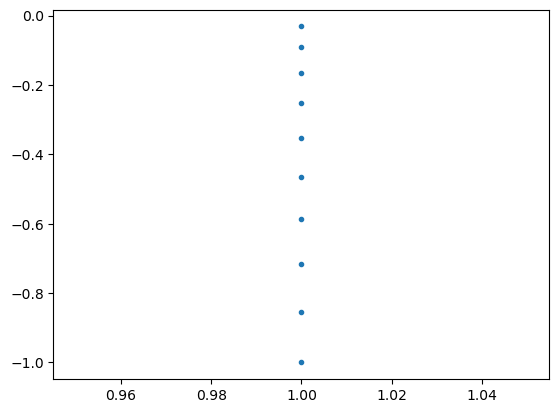

In [30]:
nlay = 10
thick = (top - botm_base)  # total model thickness
a = 1.5 # exponent to determine cell thickness
# define vertical layer fractions
# model layers get thinner near the surface
bottom_fracs = np.arange(1,nlay+1)**a/nlay**a
#print(bottom_fracs)
plt.plot(np.ones(nlay),-1*bottom_fracs,".")

In [31]:
botm = top[None, :, :] - bottom_fracs[:, None, None] * thick[None, :, :] # creates a 3D array of shape
botm[-1, :, :] = botm_base  # bottom-most layer is exactly the base elevation
# 3D domain mask
idomain3d = np.repeat(idomain2d[None, :, :], nlay, axis=0)

### DEM Fixing; assigning sea level at the right side of the model

10 100 93
THIS WILL NOT WORK IF DEM IS RESAMPLED AT DIFFERENT RESOLUTION


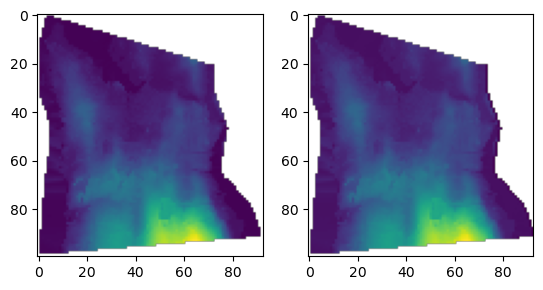

In [32]:
# Due to the removal of upper and lower Kickemuit Dams
# add low elevation cells to right to maintain constant head bounds throughout 
print(nlay, nrow,ncol)
print("THIS WILL NOT WORK IF DEM IS RESAMPLED AT DIFFERENT RESOLUTION")
plt.subplot(1,2,1)
plt.imshow(dem_resampled)

dem_fix=dem_resampled.copy()
for row in range(21,93):
    for col in range (ncol-2,60,-1):
        if ~np.isnan(dem_fix[row,col]):
            dem_fix[row,col+1]=-2
            break

plt.subplot(1,2,2)
plt.imshow(dem_fix)

dem_resampled=dem_fix.copy()

### Parameters

In [33]:
modelname = 'Warren'
K         = 10.0     # m/d
recharge  = 0.001    # m/d
porosity  = 0.30
alh, ath1, atv = 100.0, 10.0, 1.0  # dispersivities in meters

### Synthetic Tides

- Use only one type of tides to run the model
- I developed codes for both synthetic tides and tide gauge data 

In [34]:
# Tidal parameters
tidal_period_hours    = 12.0
tidal_amp             = 1.3
tidal_mean            = sea_level
omega                 = 2*np.pi/(tidal_period_hours / 24.0)   # 1/day

# Time discretization
sp_per_pd             = 12    # 12 stress periods per tidal period
num_pd                = 10   # Want to simulate 10 full tidal cycles
nper                  = 1 + sp_per_pd * num_pd # 1 is for 1 day spin up period

perlen = [1.0] + [ (tidal_period_hours/24.0)/sp_per_pd ] * (nper - 1)  # [1 day, then 1 hour]
nstp   = [1] * nper # each stress period has one time step
tsmult = [1.0] * nper

# Tide at SP end-times
times = np.cumsum(perlen)  # days
tidal_heads = tidal_mean + tidal_amp * np.sin(omega * times)

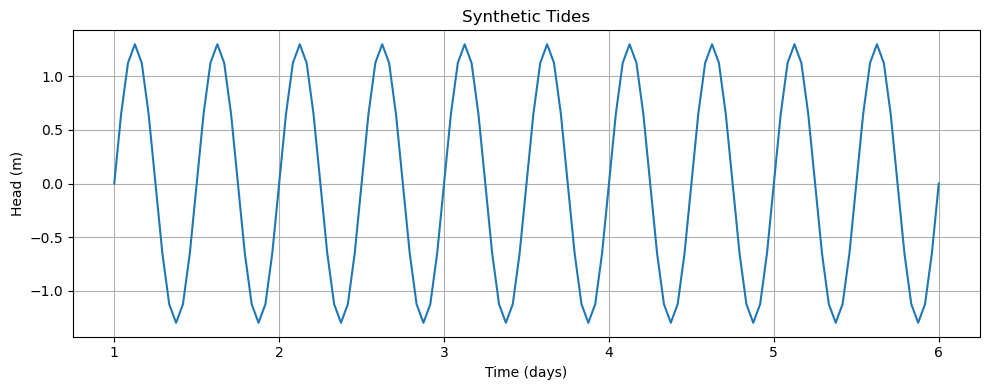

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(times, tidal_heads)
plt.xlabel("Time (days)")
plt.ylabel("Head (m)")
plt.title ("Synthetic Tides")
plt.grid(True)
plt.tight_layout()
plt.show()


### NOAA Tide Gauge Data

In [48]:
df = pd.read_csv("CO-OPS_8454000_met.csv")
df["Date Time"] = pd.to_datetime(df["Date"] + " " + df["Time (GMT)"])
df.columns = [c.strip() for c in df.columns]

df["t"] = pd.to_datetime(df["Date Time"])
df["h"] = pd.to_numeric(df["Verified (m)"], errors="coerce")  # water level (m)
df = df.dropna(subset=["h"]).sort_values("t").reset_index(drop=True)

# Time (days) since first NOAA record
t0 = df["t"].iloc[0]
t_day = (df["t"] - t0).dt.total_seconds().to_numpy() / 86400.0   # days, length N

# Perlen for each 1 hr interval (N-1 values)
perlen_1hr = np.diff(t_day)   # days
print("Min/Max dt (min):", perlen_1hr.min()*24, perlen_1hr.max()*24)

Min/Max dt (min): 0.9999999999999432 1.0000000000000284


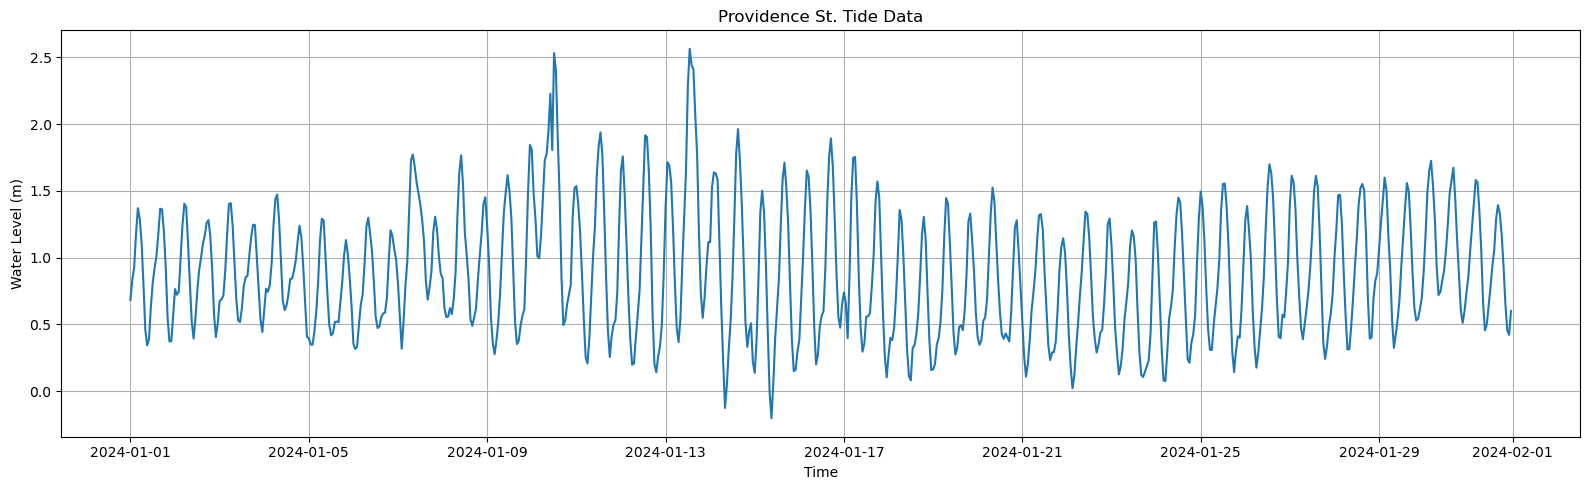

In [49]:
plt.figure(figsize=(16,5))

plt.plot(df["t"], df["h"])
plt.xlabel("Time")
plt.ylabel("Water Level (m)")
plt.title("Providence St. Tide Data")
plt.grid(True)

plt.tight_layout()
plt.show()


### Time Discretization of Tide Gauge Data

In [ ]:
# 1-day spin-up period
perlen = [1] + perlen_1hr.tolist()
nper = len(perlen)

nstp   = [1] * nper      # 1 time step per stress period
tsmult = [1.0] * nper

print("Total stress periods (nper):", nper)

In [36]:
sim = flopy.mf6.MFSimulation(sim_name=modelname, version='mf6',
                             exe_name=exe_path, sim_ws=workspace)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', nper=nper,
                             perioddata=list(zip(perlen, nstp, tsmult)))

In [37]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)

In [38]:
ims_gwf = flopy.mf6.ModflowIms(sim, pname="ims_gwf", filename="Warren_gwf.ims",
    complexity="MODERATE", linear_acceleration="CG",
    outer_maximum=200, outer_dvclose=1e-6,
    inner_maximum=100, inner_dvclose=1e-6, rcloserecord=1e-6,
)

sim.register_ims_package(ims_gwf, [gwf.name])

In [39]:
# discretization (DIS)
flopy.mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc, top=top, botm=botm, idomain=idomain3d
);


In [40]:
# Initial Condition (IC)
# Initial heads: 2D field replicated to 3D
ICs2d = np.where(idomain2d == 1, np.maximum(top, sea_level), sea_level)
ICs3d = np.repeat(ICs2d[None, :, :], nlay, axis=0)
flopy.mf6.ModflowGwfic(gwf, strt=ICs3d);

In [41]:
# NPF and STO Packages
icelltype = [1]*nlay # 1 is convertible for all layers
flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=K)
flopy.mf6.ModflowGwfsto(gwf, iconvert=icelltype, sy=0.15, ss=1e-5, steady_state={0: False});

In [43]:
# Recharge (layer 1) over land above sea level; AUX conc = 0

drn_leakthick   = 0.50  # m
drn_cond_mult   = 0.10  # scale conductance
cell_area = float(delr) * float(delc)
cond  = drn_cond_mult * K * cell_area / max(drn_leakthick, 1e-6)

# loop through rows and cols, assign recharge value if >sl, 0 if <sl
rch_spd = [] 
drn_spd = []
chd_spd = []
for r in range(nrow):
    for c in range(ncol):
        if top[r, c]>sea_level:
            rch_spd.append([(0, r, c), float(recharge), 0.0])
            drn_spd.append([(0, r,c), float(top[r,c]), float(cond)])
        elif top[r,c]<sea_level:
            chd_spd.append([(0, r,c), sea_level])  
if gwf.get_package("RCH") is not None:
    gwf.remove_package("RCH")            
rch = flopy.mf6.ModflowGwfrch(
    gwf, pname="RCH",
    auxiliary=["CONCENTRATION"],
    maxbound=len(rch_spd),
    stress_period_data=rch_spd,
    save_flows=True
)

if gwf.get_package("DRN") is not None:
    gwf.remove_package("DRN")
drn = flopy.mf6.ModflowGwfdrn(
    gwf, pname="DRN",
    maxbound=len(drn_spd),
    stress_period_data=drn_spd,
    save_flows=True
)


if gwf.get_package("CHD") is not None:
    gwf.remove_package("CHD")
chd = flopy.mf6.ModflowGwfchd(
    gwf, pname='CHD',
    stress_period_data=chd_spd,
    maxbound=len(chd_spd)
)

In [44]:
# GWF Output control (OC)
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f'{modelname}.hds',
    budget_filerecord=f'{modelname}.cbc',
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('BUDGET', 'LAST')]
);

In [45]:
# 7) Write & Run

sim.write_simulation()
success, buff = sim.run_simulation()
print("Success:", success)
if not success:
    raise RuntimeError("MODFLOW 6 did not terminate normally.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_gwf...
  writing model Warren...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rch...
    writing package drn...
    writing package chd...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\WRDAPP\modflow_executables-22.0-win64\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been s

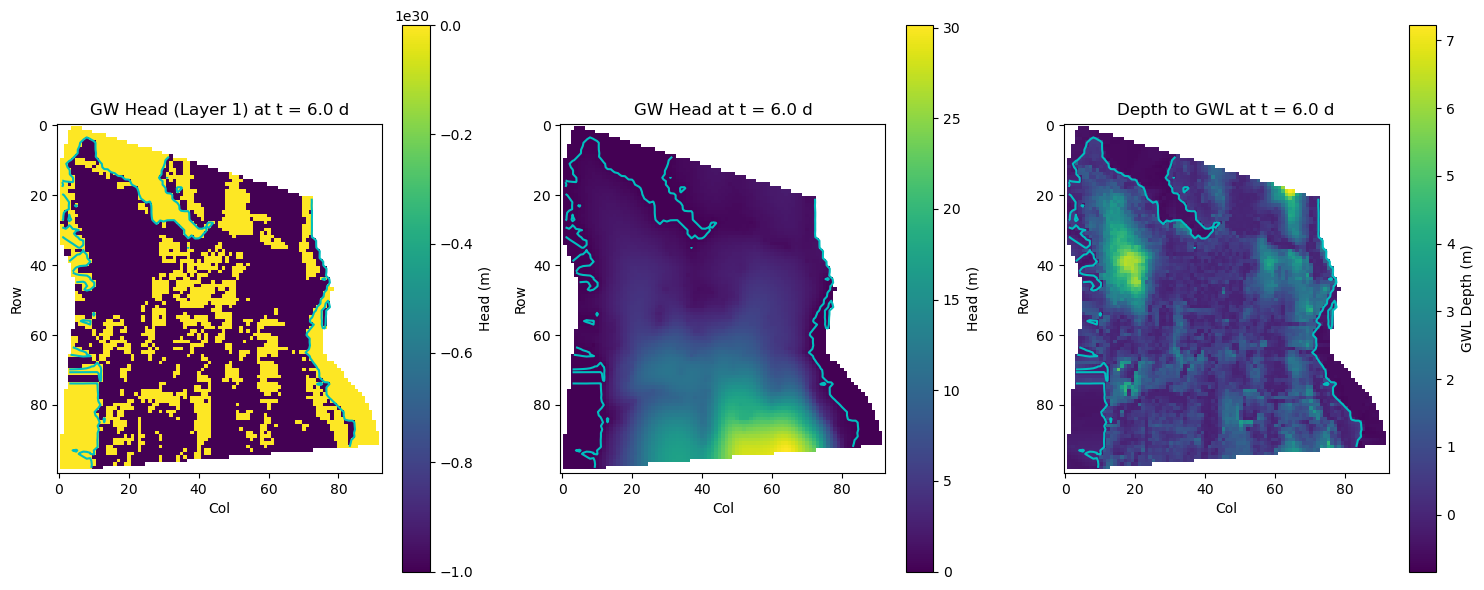

In [46]:
from flopy.utils import HeadFile, CellBudgetFile

# Load heads at final time
hds = HeadFile(os.path.join(workspace, f"{modelname}.hds"), text="HEAD")
times = hds.get_times()
H = hds.get_data(totim=times[-1]).astype(float)   # (nlay,nrow,ncol)
H[H > 1e20] = np.nan

# Mask inactive
idom3d = idomain3d if np.ndim(idomain3d)==3 else np.repeat(idomain2d[None,:,:], H.shape[0], axis=0)
H[idom3d == 0] = np.nan

WT=np.nanmax(H, axis=0)



# Plots
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plot_layer=0
im = plt.imshow(H[plot_layer], origin="upper", cmap="viridis")
plt.contour(dem_resampled,0,colors='c')
plt.colorbar(im, label="Head (m)")
plt.title(f"GW Head (Layer 1) at t = {times[-1]:.1f} d")
#plt.title(f"Head at t = {times[-1]:.1f} d")
plt.xlabel("Col"); plt.ylabel("Row")

plt.subplot(1,3,2)
plot_layer=1
#im = plt.imshow(H[plot_layer], origin="upper", cmap="viridis")
im = plt.imshow(WT, origin="upper", cmap="viridis")
plt.contour(dem_resampled,0,colors='c')
plt.colorbar(im, label="Head (m)")
#plt.title(f"Head (Layer 1) at t = {times[-1]:.1f} d")
plt.title(f"GW Head at t = {times[-1]:.1f} d")
plt.xlabel("Col"); plt.ylabel("Row")

plt.subplot(1,3,3)
im = plt.imshow(dem_resampled-WT, origin="upper", cmap="viridis")
plt.contour(dem_resampled,0,colors='c')
plt.colorbar(im, label="GWL Depth (m)")
#plt.title(f"Head (Layer 1) at t = {times[-1]:.1f} d")
plt.title(f"Depth to GWL at t = {times[-1]:.1f} d")
plt.xlabel("Col"); plt.ylabel("Row")

plt.tight_layout()
plt.show()

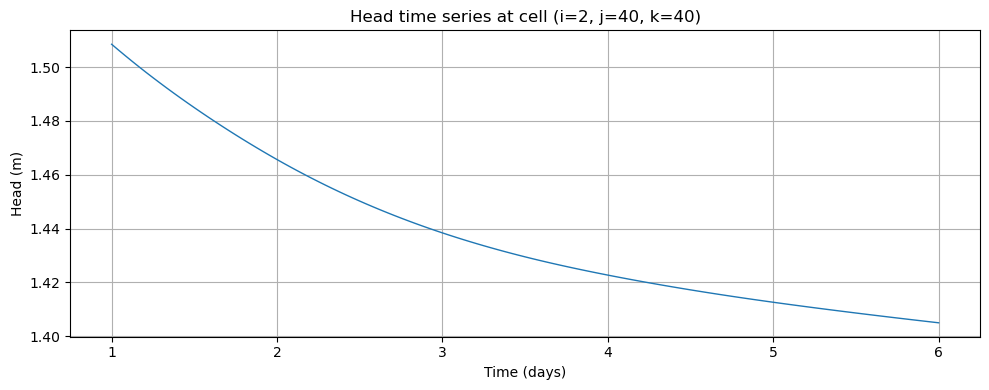

In [47]:
# Choose the cell (0-based indices!)
i = 2   # e.g., Layer 2  (layer 1 on paper → k=0; layer 2 → k=1)
j = 40  # pick a row index
k = 40  # pick a column index

# Get head time series for that cell
ts = hds.get_ts((i, j, k))  # shape (ntimes, 2): [time, head]

# Separate time and head
time = ts[:, 0]   # days
head = ts[:, 1]   # m

# Some MF6 outputs use very large numbers for dry/inactive cells
head = np.where(head > 1e20, np.nan, head)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time, head, linewidth=1)
plt.xlabel("Time (days)")
plt.ylabel("Head (m)")
plt.title(f"Head time series at cell (i={i}, j={j}, k={k})")
plt.grid(True)
plt.tight_layout()
plt.show()
